<a href="https://colab.research.google.com/github/mariduff/DATASCIENCE_BI/blob/main/notebooks/Entrenamiento_prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Leer el Excel limpio
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/TFM/ETL_analisis_centro_limpio.xlsx')

Antes de trabajar la PCA vamos a ver qué hacemos con los nulos que siguen existiendo en algunas variables.

In [12]:
nulls = df.isnull().sum().to_frame(name='Nulos')
nulls['% Nulos'] = (nulls['Nulos'] / len(df) * 100).round(2)
nulls = nulls[nulls['Nulos'] > 0].sort_values('% Nulos', ascending=False)

nulls

,Nulos,% Nulos
Maternidad,2454,55.91
Horas sindicales,1606,36.59
Permiso sin sueldo,1560,35.54
AT / EP,1309,29.82
FTE reemplazo Vacaciones,657,14.97
Días Asuntos Propios,539,12.28
Permiso retribuido,284,6.47
Vacaciones,129,2.94
EC / ANL,15,0.34
EC_ANL_relativo,15,0.34


Analizando:
- Maternidad, horas sindicales, permiso sin sueldo, AT/EP, Dias asuntos propios y permiso retribuido los nulos podemos transformarlos a 0, porque es la realidad, hay ausencia de ello.

En el caso de FTE reemplazo vacaciones y vacaciones cogemos la media
EC / ANL es mejor no imputarlo con 0 porque de esta variable viene nuestra target (relativo).
EC/ANL Relativo es nuestro target, y por tanto no podemos poner 0, ponemos también la media.
FTE Absentismo, Absentismo_relativo y plantilla total absentismo podemos poner la media también:

In [13]:

df_imputado = df.copy()

#Imputar con media
cols_media = [
    'EC / ANL', 'EC_ANL_relativo',
    'FTE Absentismo', 'Absentismo_relativo',
    'Plantilla Total Absentismo', 'Vacaciones', 'FTE reemplazo Vacaciones'
]
for col in cols_media:
    df_imputado[col] = df_imputado[col].fillna(df_imputado[col].mean())

#Imputar con 0 (ausencia = no ocurrió)
cols_cero = [
    'Maternidad', 'Horas sindicales', 'Permiso sin sueldo',
    'AT / EP', 'Días Asuntos Propios', 'Permiso retribuido'
]
df_imputado[cols_cero] = df_imputado[cols_cero].fillna(0)

#Comprobación final
nulos_restantes = df_imputado.isnull().sum()
print("Nulos restantes por columna:\n", nulos_restantes[nulos_restantes > 0])


✅ Nulos restantes por columna:
 Series([], dtype: int64)


Eliminamos las columnas que no queremos incluir en la PCA (CD_CENTRO, fecha y target)


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Excluimos columnas no numéricas o no predictoras
X = df_imputado.drop(columns=["Mes", "MesAno", "CD_CENTRO", "EC_ANL_relativo"])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Aplicamos PCA

In [20]:
# Aplicamos PCA sin limitar el número de componentes (los usaremos luego según varianza explicada)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Creamos un DataFrame con los componentes
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Añadimos la variable target al final (por si queremos usarla para colorear, modelar, etc.)
df_pca["EC_ANL_relativo"] = df_imputado["EC_ANL_relativo"].values


Realizamos Scree Plot para ver cuántos componentes explican el 80-90% de la varianza.

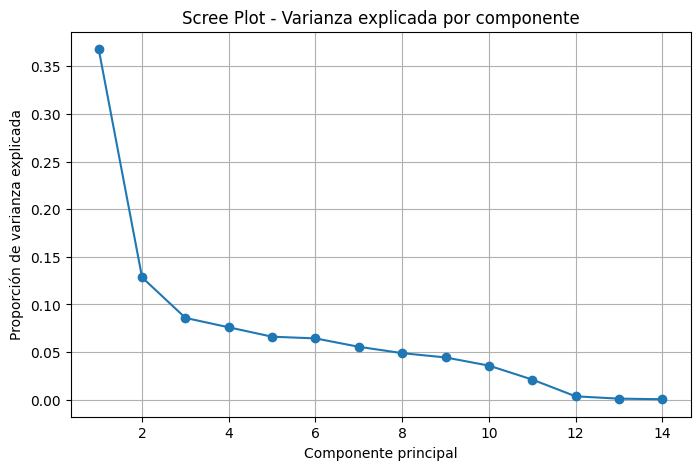

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_,
         marker='o')
plt.title("Scree Plot - Varianza explicada por componente")
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza explicada")
plt.grid(True)
plt.show()


El componente principal (1) explica aproximadamente 35% de la varianza total, el 2 explica alrededor del 14% (50% aprox ya explicado con los primeros 2 componentes).
A partir del 7 las aportaciones son menores (<5%), lo que sugiere rendimientos decrecientes.

In [23]:
# Comprobamos los tipos de datos para asegurar que no hay nulos
print(X.dtypes)


FTE Contratación              float64
FTE Absentismo                float64
Plantilla Total Absentismo    float64
AT / EP                       float64
Días Asuntos Propios          float64
EC / ANL                      float64
Horas sindicales              float64
Maternidad                    float64
Permiso retribuido            float64
Permiso sin sueldo            float64
Vacaciones                    float64
FTE reemplazo Vacaciones      float64
Tasa_Ocupacion                float64
Absentismo_relativo           float64
dtype: object


In [26]:
# Eliminar columna 'Mes' antes de aplicar el escalado
X = df_imputado.drop(columns=["Mes", "MesAno", "CD_CENTRO", "EC_ANL_relativo"])

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada acumulada
var_exp = pca.explained_variance_ratio_
var_cumsum = np.cumsum(var_exp)

# Mostrar tabla
for i, var in enumerate(var_cumsum):
    print(f"Componentes: {i+1} - Varianza acumulada: {var:.4f}")


Componentes: 1 - Varianza acumulada: 0.3678
Componentes: 2 - Varianza acumulada: 0.4963
Componentes: 3 - Varianza acumulada: 0.5822
Componentes: 4 - Varianza acumulada: 0.6582
Componentes: 5 - Varianza acumulada: 0.7244
Componentes: 6 - Varianza acumulada: 0.7887
Componentes: 7 - Varianza acumulada: 0.8443
Componentes: 8 - Varianza acumulada: 0.8932
Componentes: 9 - Varianza acumulada: 0.9376
Componentes: 10 - Varianza acumulada: 0.9735
Componentes: 11 - Varianza acumulada: 0.9947
Componentes: 12 - Varianza acumulada: 0.9983
Componentes: 13 - Varianza acumulada: 0.9994
Componentes: 14 - Varianza acumulada: 1.0000


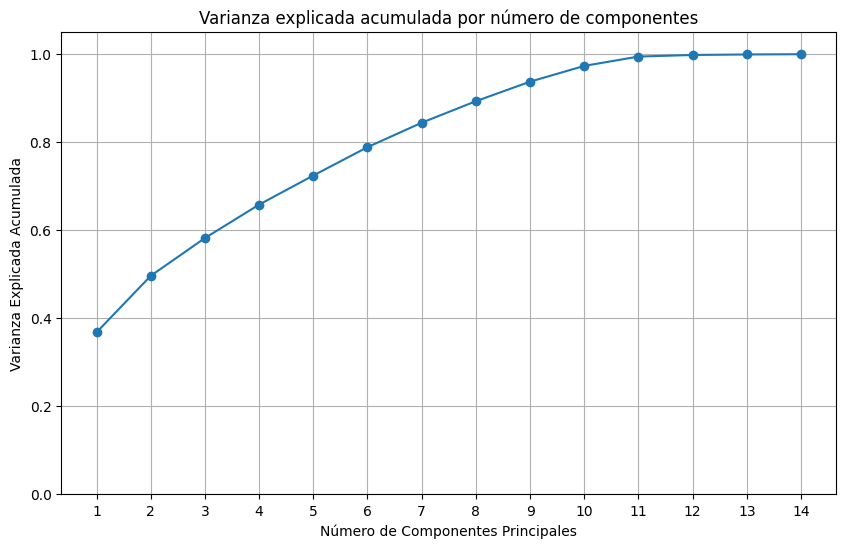

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Eliminar columnas no predictoras y la columna problemática 'Mes'
X = df_imputado.drop(columns=["Mes", "MesAno", "CD_CENTRO", "EC_ANL_relativo"])

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Varianza explicada
var_exp = pca.explained_variance_ratio_
var_cumsum = np.cumsum(var_exp)

# 5. Plot varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_cumsum) + 1), var_cumsum, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza explicada acumulada por número de componentes')
plt.grid(True)
plt.xticks(range(1, len(var_cumsum) + 1))
plt.ylim(0, 1.05)
plt.show()


9 componentes ya nos explicarían un 95% de la varianza y 10 componentes ya cubrirían casi el 100%. Podemos reducir el modelo de 14 a 10.

Avanzamos con la regresión lineal múltiple usando los 10 primeros componentes principales del PCA como variables predictivas para predecir EC_ANL_relativo

🔎 Evaluación del modelo:
MAE:  0.0081
RMSE: 0.0108
R²:   0.9281


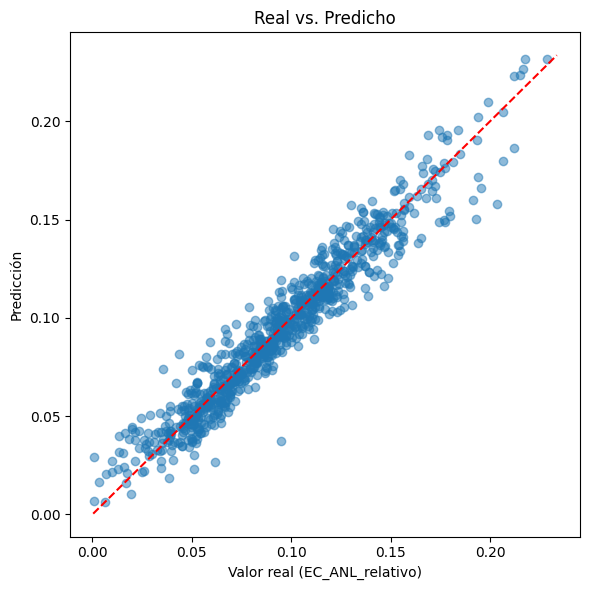

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 1. Reducimos a las 10 componentes principales
pca_10 = PCA(n_components=10)
X_pca_10 = pca_10.fit_transform(X_scaled)

# 2. Definimos variable target
y = df_imputado["EC_ANL_relativo"]

# 3. Dividimos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_pca_10, y, test_size=0.2, random_state=42)

# 4. Entrenamos modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predicciones
y_pred = model.predict(X_test)

# 6. Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("🔎 Evaluación del modelo:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# 7. Visualizamos resultados
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel("Valor real (EC_ANL_relativo)")
plt.ylabel("Predicción")
plt.title("Real vs. Predicho")
plt.tight_layout()
plt.show()


El modelo de regresión lineal sobre los 10 componentes principales del PCA ha dado unos resultados excelentes
MAE (error absoluto medio): 0.0081
RMSE (error cuadrático medio): 0.0108
R2 (Coeficiente de determinación): 0.9281 -> lo que indica que el 92,81% de la varianza del EC_ANL_relativo está explicada por los componentes principales, es una predicción muy sólida.

Vamos a analizar con Ramdom Forest con los 10 componentes:

 Evaluación - Random Forest:
MAE : 0.00875
RMSE: 0.01137
R²  : 0.91974


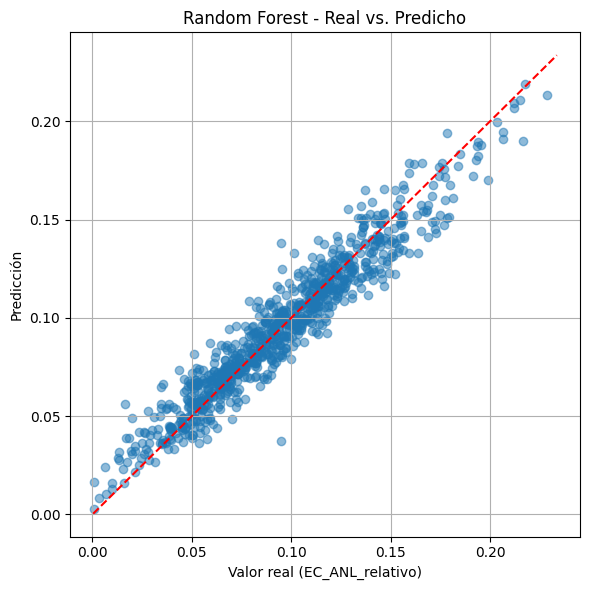

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# División train/test (si no está hecha ya)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca_10, y, test_size=0.2, random_state=42)

# Entrenar modelo
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Mostrar resultados
print(" Evaluación - Random Forest:")
print(f"MAE : {mae_rf:.5f}")
print(f"RMSE: {rmse_rf:.5f}")
print(f"R²  : {r2_rf:.5f}")

# Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real (EC_ANL_relativo)")
plt.ylabel("Predicción")
plt.title("Random Forest - Real vs. Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


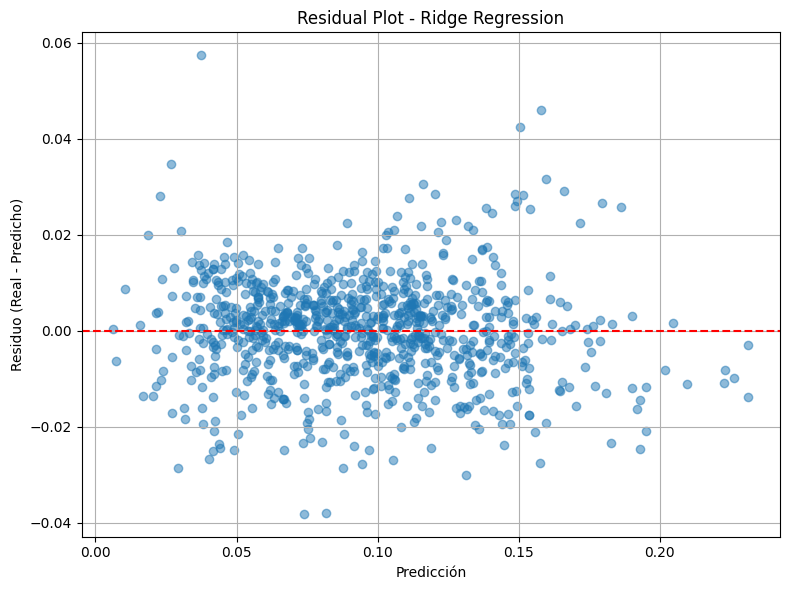

🔍 Evaluación – Ridge Regression:
MAE : 0.00806
RMSE: 0.01076
R²  : 0.92806


In [33]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca_10, y, test_size=0.2, random_state=42)

# 2. Modelo Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# 3. Métricas
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# 4. Residual plot
residuals = y_test - y_pred_ridge

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ridge, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Ridge Regression")
plt.xlabel("Predicción")
plt.ylabel("Residuo (Real - Predicho)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Mostrar métricas
print("🔍 Evaluación – Ridge Regression:")
print(f"MAE : {mae_ridge:.5f}")
print(f"RMSE: {rmse_ridge:.5f}")
print(f"R²  : {r2_ridge:.5f}")


Vemos una gráfica de residuos:
La nube de puntos se reparte aleatoriamente alrededor de 0, sin patrones evidentes -> esto sugiere que el modelo no deja errores sistemáticos, lo cual es bueno.

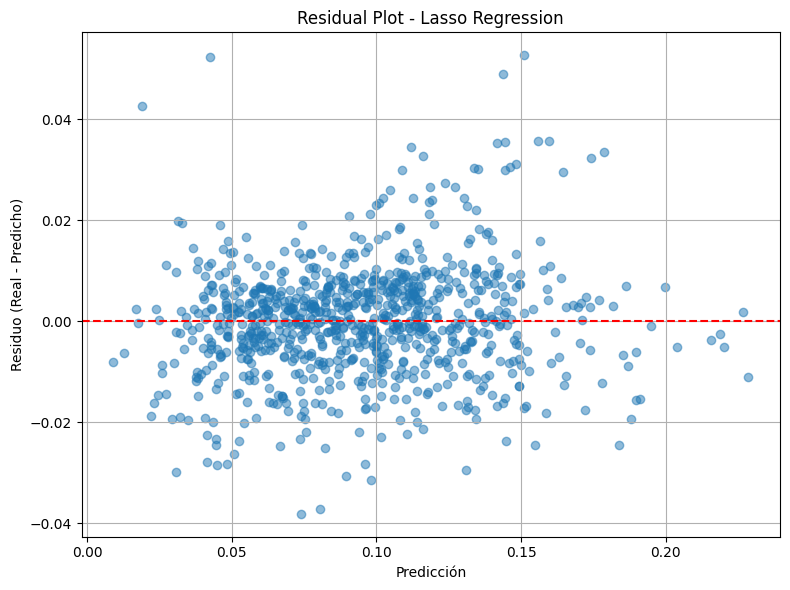

🔍 Evaluación – Lasso Regression:
MAE : 0.00823
RMSE: 0.01119
R²  : 0.92214


In [35]:
from sklearn.linear_model import Lasso

# 1. Entrenar modelo
lasso_model = Lasso(alpha=0.001, random_state=42)
lasso_model.fit(X_train, y_train)

# 2. Predicciones
y_pred_lasso = lasso_model.predict(X_test)

# 3. Métricas
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# 4. Residual plot
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Lasso Regression")
plt.xlabel("Predicción")
plt.ylabel("Residuo (Real - Predicho)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Mostrar métricas
print("🔍 Evaluación – Lasso Regression:")
print(f"MAE : {mae_lasso:.5f}")
print(f"RMSE: {rmse_lasso:.5f}")
print(f"R²  : {r2_lasso:.5f}")


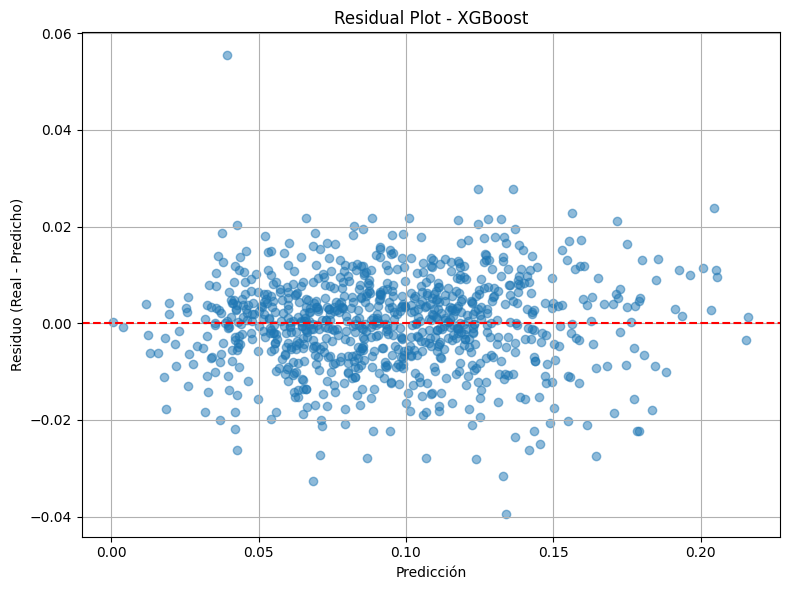

🔍 Evaluación – XGBoost:
MAE : 0.00746
RMSE: 0.00975
R²  : 0.94097


In [36]:
from xgboost import XGBRegressor

# 1. Entrenar modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# 2. Predicción
y_pred_xgb = xgb_model.predict(X_test)

# 3. Métricas
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# 4. Residual plot
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Residuo (Real - Predicho)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Mostrar métricas
print("🔍 Evaluación – XGBoost:")
print(f"MAE : {mae_xgb:.5f}")
print(f"RMSE: {rmse_xgb:.5f}")
print(f"R²  : {r2_xgb:.5f}")


XGBoost es el mejor modelo hasta ahora, pero podemos hacer ajuste de hiperparámetros para buscar un mejor resultado aún:

In [37]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Definimos el espacio de búsqueda
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.5, 1, 1.5, 2]
}

# 2. Modelo base
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

# 3. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,  # nº de combinaciones aleatorias
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Entrenamiento con las 10 componentes principales
random_search.fit(X_train, y_train)

# 5. Mejores hiperparámetros
print("Mejores hiperparámetros:")
print(random_search.best_params_)

# 6. Evaluación
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🔍 Evaluación – XGBoost con hiperparámetros:")
print(f"MAE : {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²  : {r2:.5f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Mejores hiperparámetros:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

🔍 Evaluación – XGBoost con hiperparámetros:
MAE : 0.00821
RMSE: 0.01064
R²  : 0.92971


Habiendo analizado con ajuste de hiperparámetros, el XGBoost sin ajuste de hiperparámetros ha sido el que mejor resultados ha dado.

| Modelo                   | MAE         | RMSE        | R²            |
| ------------------------ | ----------- | ----------- | ------------- |
| **XGBoost (sin tuning)** | **0.00746** | **0.00975** | **0.94097** ✅ |
| XGBoost (con tuning)     | 0.00821     | 0.01064     | 0.92971       |
| Ridge Regression         | 0.00806     | 0.01076     | 0.92806       |
| Linear Regression (PCA)  | 0.00810     | 0.01080     | 0.92810       |
| Lasso Regression         | 0.00823     | 0.01119     | 0.92214       |
| Random Forest            | 0.00875     | 0.01137     | 0.91974       |


Vamos a cargar el modelo entrenado:

In [38]:
import joblib

# Guardar el modelo XGBoost (sin ajuste de hiperparámetros)
joblib.dump(xgb_model, "xgb_model_final.pkl")


['xgb_model_final.pkl']

------ texto ---------




texto -------

/tmp/ipython-input-4109847216.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


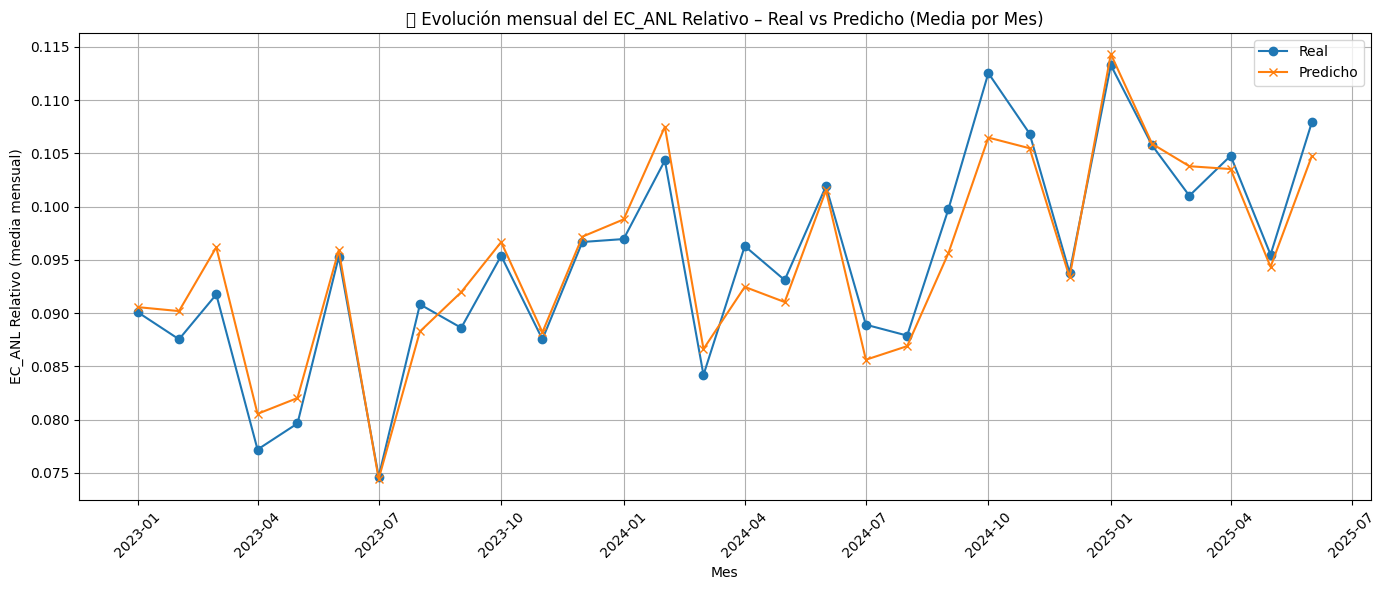

In [40]:
# Añadir las fechas y predicciones al DataFrame de test
df_pred_full = pd.DataFrame({
    "MesAno": df_imputado.loc[X_test_idx, "MesAno"],
    "Real": y_test.values,
    "Pred": xgb_model.predict(X_test)
})

# Agrupamos por Mes y hacemos la media
df_mensual = df_pred_full.groupby("MesAno").mean().reset_index()

# Graficamos
plt.figure(figsize=(14,6))
plt.plot(df_mensual["MesAno"], df_mensual["Real"], label="Real", marker='o')
plt.plot(df_mensual["MesAno"], df_mensual["Pred"], label="Predicho", marker='x')
plt.title("📈 Evolución mensual del EC_ANL Relativo – Real vs Predicho (Media por Mes)")
plt.xlabel("Mes")
plt.ylabel("EC_ANL Relativo (media mensual)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


Podemos confirmar que el modelo sigue muy bien la tendencia y los picos, lo cual es una muy buena señal de que generaliza bien a lo largo del tiempo.

Aprovechando que XGBoost ha dado muy buenos resultados, vamos a utilizarlo para realizar predicción futura utilizando una secuencia temporal pasada para predecir futuro.

Como el objetivo del TFM es una predicción por centro para poder lograr gestionar las bajas, vamos arealizar una predicción por centro:

Como la idea es hacer una predicción de 6 meses, vamos a preparar lags para 6 meses.

In [41]:
# Paso 1: Crear columnas de lags de EC_ANL_relativo por centro (hasta 6 meses)
df_lags = df_imputado.copy()
df_lags = df_lags.sort_values(by=["CD_CENTRO", "MesAno"])

# Creamos lags desde t-1 hasta t-6
for lag in range(1, 7):
    df_lags[f"EC_ANL_relativo_t-{lag}"] = df_lags.groupby("CD_CENTRO")["EC_ANL_relativo"].shift(lag)

# Eliminamos las filas incompletas (con NaNs en alguno de los lags)
df_lags_limpio = df_lags.dropna(subset=[f"EC_ANL_relativo_t-{lag}" for lag in range(1, 7)]).copy()

# Mostramos ejemplo
df_lags_limpio[["CD_CENTRO", "MesAno", "EC_ANL_relativo"] + [f"EC_ANL_relativo_t-{lag}" for lag in range(1, 7)]].head()


,CD_CENTRO,MesAno,EC_ANL_relativo,EC_ANL_relativo_t-1,EC_ANL_relativo_t-2,EC_ANL_relativo_t-3,EC_ANL_relativo_t-4,EC_ANL_relativo_t-5,EC_ANL_relativo_t-6
939,CENTRO102,2023-07-01,0.055399,0.055167,0.053272,0.070378,0.034100,0.037502,0.058534
1085,CENTRO102,2023-08-01,0.053083,0.055399,0.055167,0.053272,0.070378,0.034100,0.037502
1231,CENTRO102,2023-09-01,0.049101,0.053083,0.055399,0.055167,0.053272,0.070378,0.034100
1377,CENTRO102,2023-10-01,0.029792,0.049101,0.053083,0.055399,0.055167,0.053272,0.070378
1523,CENTRO102,2023-11-01,0.024821,0.029792,0.049101,0.053083,0.055399,0.055167,0.053272


In [44]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Features (lags)
features = [f"EC_ANL_relativo_t-{i}" for i in range(1, 7)]
target = "EC_ANL_relativo"

# Preparamos X e y
X = df_lags_limpio[features]
y = df_lags_limpio[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Entrenamiento modelo
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predicción test
y_pred = xgb_model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluación modelo general autoregresivo:")
print(f"MAE : {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R²  : {r2:.5f}")


📊 Evaluación modelo general autoregresivo:
MAE : 0.01510
RMSE: 0.01954
R²  : 0.77223


In [45]:
from datetime import timedelta

# Asegurar que 'MesAno' es datetime
df_lags_limpio["MesAno"] = pd.to_datetime(df_lags_limpio["MesAno"])

# Obtenemos último mes del dataset
ultimo_mes = df_lags_limpio["MesAno"].max()

# Lista para almacenar resultados
resultados = []

# Centros únicos
centros = df_lags_limpio["CD_CENTRO"].unique()

# Iteramos por cada centro
for centro in centros:
    # Extraer datos del centro y ordenar por fecha
    datos_centro = df_lags_limpio[df_lags_limpio["CD_CENTRO"] == centro].sort_values("MesAno")

    # Últimos 6 valores reales
    historial = datos_centro.tail(6)["EC_ANL_relativo"].tolist()

    # Asegurarnos de tener 6 valores válidos
    if len(historial) < 6 or np.any(pd.isnull(historial)):
        continue  # Saltar centros incompletos

    # Generar predicciones para 6 meses
    for i in range(1, 7):
        # Crear input para el modelo
        input_lags = np.array(historial[-6:]).reshape(1, -1)
        pred = xgb_model.predict(input_lags)[0]

        # Generar mes futuro
        mes_futuro = ultimo_mes + pd.DateOffset(months=i)

        # Guardar resultado
        resultados.append({
            "CD_CENTRO": centro,
            "MesAno": mes_futuro,
            "EC_ANL_relativo_pred": pred
        })

        # Añadir la predicción al historial para siguientes pasos
        historial.append(pred)

# Convertimos a DataFrame
df_predicciones = pd.DataFrame(resultados)

# Vista previa
df_predicciones.head()


,CD_CENTRO,MesAno,EC_ANL_relativo_pred
0,CENTRO102,2025-07-01,0.106743
1,CENTRO102,2025-08-01,0.087578
2,CENTRO102,2025-09-01,0.098137
3,CENTRO102,2025-10-01,0.084844
4,CENTRO102,2025-11-01,0.075766


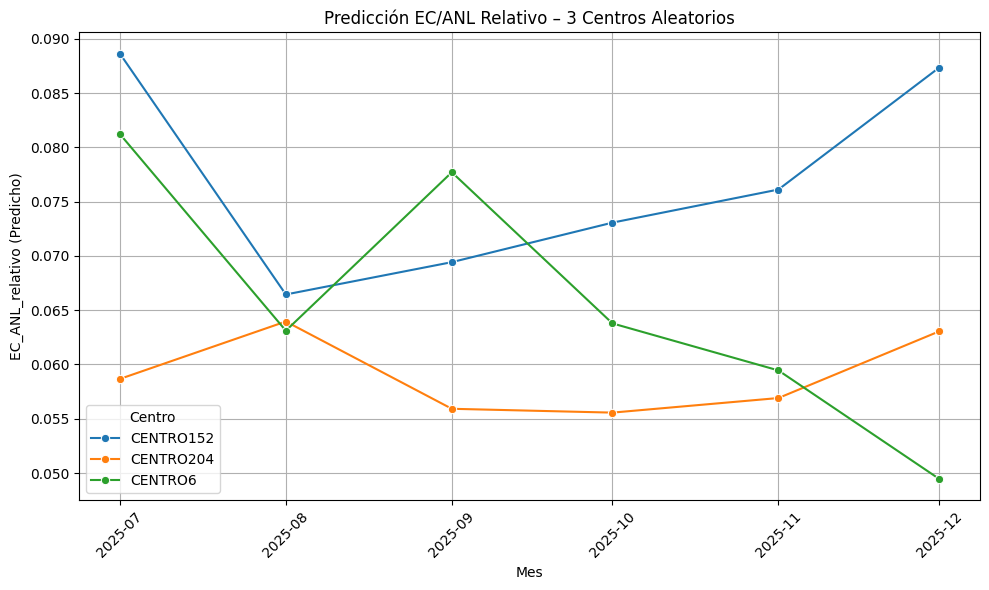

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elegimos 3 centros aleatoriamente
centros_muestra = df_predicciones["CD_CENTRO"].dropna().unique()
centros_aleatorios = np.random.choice(centros_muestra, size=3, replace=False)

# Filtramos predicciones de esos centros
df_vista = df_predicciones[df_predicciones["CD_CENTRO"].isin(centros_aleatorios)]

# Gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_vista, x="MesAno", y="EC_ANL_relativo_pred", hue="CD_CENTRO", marker="o")

plt.title("Predicción EC/ANL Relativo – 3 Centros Aleatorios")
plt.xlabel("Mes")
plt.ylabel("EC_ANL_relativo (Predicho)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Centro")
plt.show()


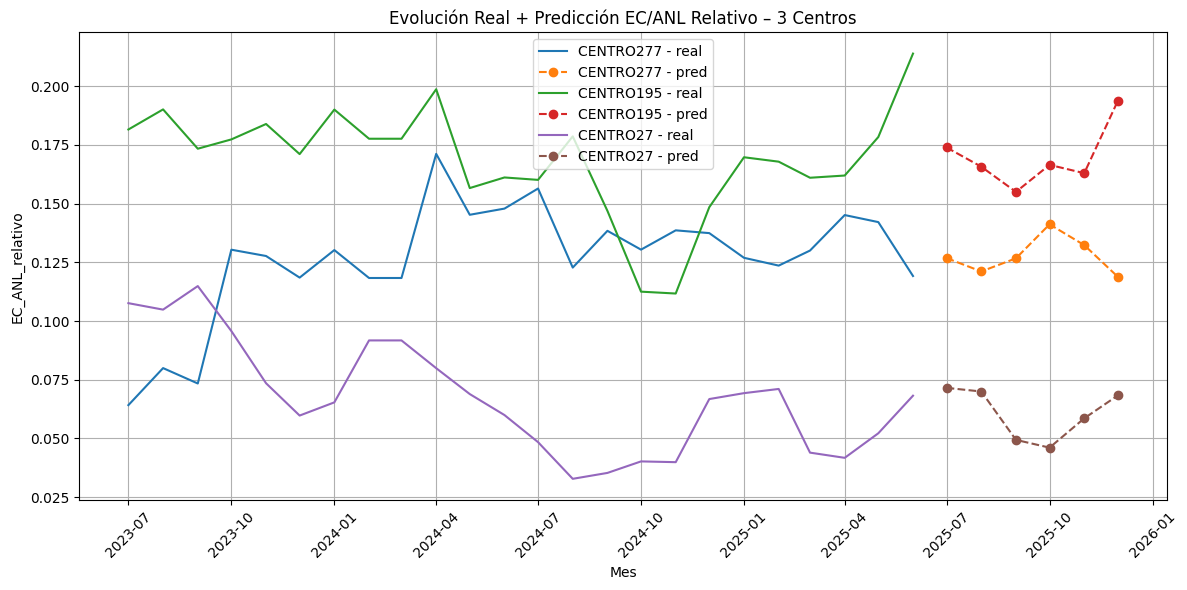

In [47]:
# Elegir 3 centros aleatorios (los mismos si quieres)
centros_disponibles = df_predicciones["CD_CENTRO"].unique()
centros_aleatorios = np.random.choice(centros_disponibles, size=3, replace=False)

plt.figure(figsize=(12, 6))

for centro in centros_aleatorios:
    # Reales
    df_real = df_lags_limpio[df_lags_limpio["CD_CENTRO"] == centro][["MesAno", "EC_ANL_relativo"]]
    df_real = df_real.sort_values("MesAno").dropna()

    # Predichos
    df_pred = df_predicciones[df_predicciones["CD_CENTRO"] == centro]

    # Línea real
    plt.plot(df_real["MesAno"], df_real["EC_ANL_relativo"], label=f"{centro} - real")

    # Línea predicción (discontinua)
    plt.plot(df_pred["MesAno"], df_pred["EC_ANL_relativo_pred"], linestyle="--", marker="o", label=f"{centro} - pred")

# Estética
plt.title("Evolución Real + Predicción EC/ANL Relativo – 3 Centros")
plt.xlabel("Mes")
plt.ylabel("EC_ANL_relativo")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


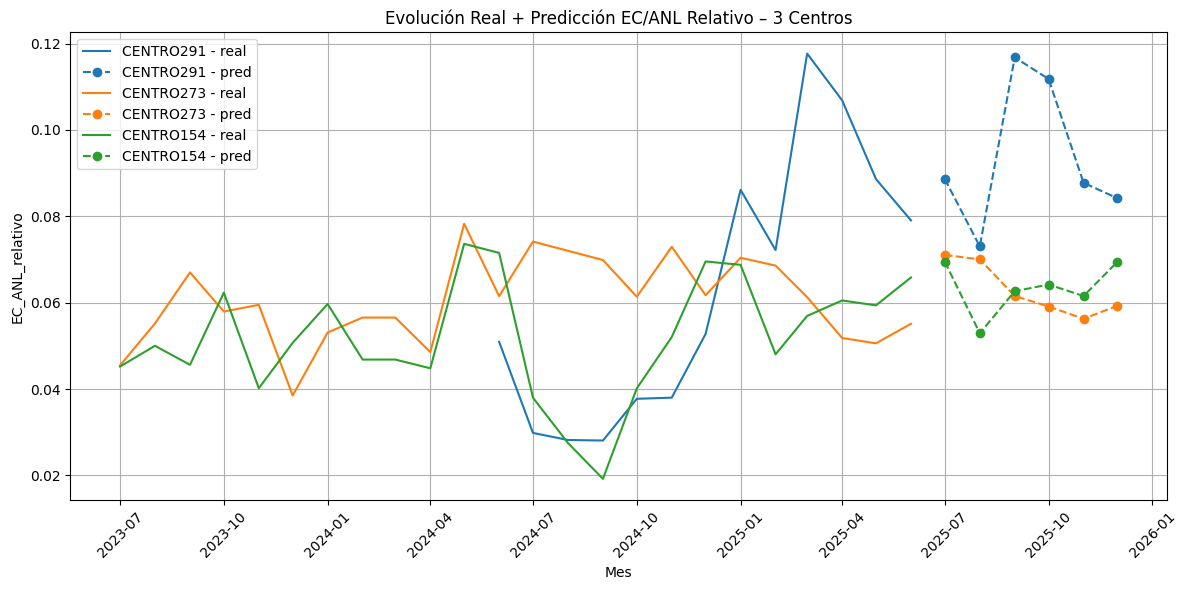

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elegimos 3 centros aleatorios (puedes fijarlos si quieres)
centros_disponibles = df_predicciones["CD_CENTRO"].unique()
centros_aleatorios = np.random.choice(centros_disponibles, size=3, replace=False)

# Paleta de colores para los 3 centros
colores = sns.color_palette("tab10", n_colors=3)
color_map = dict(zip(centros_aleatorios, colores))

# Gráfico
plt.figure(figsize=(12, 6))

for centro in centros_aleatorios:
    # Reales
    df_real = df_lags_limpio[df_lags_limpio["CD_CENTRO"] == centro].sort_values("MesAno")
    df_real = df_real[["MesAno", "EC_ANL_relativo"]].dropna()

    # Predichos
    df_pred = df_predicciones[df_predicciones["CD_CENTRO"] == centro]

    # Mismo color para real y predicho
    color = color_map[centro]

    # Línea real
    plt.plot(df_real["MesAno"], df_real["EC_ANL_relativo"],
             label=f"{centro} - real", color=color)

    # Línea predicha (discontinua)
    plt.plot(df_pred["MesAno"], df_pred["EC_ANL_relativo_pred"],
             linestyle="--", marker="o", label=f"{centro} - pred", color=color)

# Estética
plt.title("Evolución Real + Predicción EC/ANL Relativo – 3 Centros")
plt.xlabel("Mes")
plt.ylabel("EC_ANL_relativo")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
# Convertimos a DataFrame
df_predicciones = pd.DataFrame(resultados)


/content/drive/MyDrive/TFM/ETL_analisis_centro_limpio.xlsx

In [52]:
# Guardar como Excel
excel_path = "/content/drive/MyDrive/TFM/data/processed/predicciones_6_meses_por_centro.xlsx"
df_predicciones.to_excel(excel_path, index=False)

# Guardar como CSV
csv_path = "/content/drive/MyDrive/TFM/data/processed/predicciones_6_meses_por_centro.csv"
df_predicciones.to_csv(csv_path, index=False)

print("Archivos guardados:")
print(f"Excel: {excel_path}")
print(f"CSV  : {csv_path}")


✅ Archivos guardados:
Excel: /content/drive/MyDrive/TFM/data/processed/predicciones_6_meses_por_centro.xlsx
CSV  : /content/drive/MyDrive/TFM/data/processed/predicciones_6_meses_por_centro.csv


De esta forma en Power BI ya podemos hacer visualizaciones por centro añadiendo esta predicción.